In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('lending_club_ml.csv')
df.drop(['id'], inplace=True, axis=1)
df.info()

C:\Users\leero\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506738 entries, 0 to 2506737
Columns: 104 entries, loan_amnt to length_of_cr
dtypes: float64(92), int64(3), object(9)
memory usage: 1.9+ GB


In [3]:
for thing in df:
    if df[thing].dtype == 'object':
        print(thing)

grade
sub_grade
home_ownership
verification_status
purpose
initial_list_status
application_type
verification_status_joint
disbursement_method


In [4]:
# creating columns for features that had more than 2 outcomes
# I have decided to use subgrade and not grade as these are suppose to be similar features but, subgrade is more granular

df = pd.concat([df, pd.get_dummies(
    df.sub_grade, prefix='sub_grade', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df.home_ownership,
                                   prefix='home_ownership', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df.verification_status,
                                   prefix='verification_status', drop_first=True)], axis=1)
df = pd.concat(
    [df, pd.get_dummies(df.purpose, prefix='purpose', drop_first=True)], axis=1)
df = pd.concat([df, pd.get_dummies(df.verification_status_joint,
                                   prefix='verification_status_joint', drop_first=True)], axis=1)

df.drop(columns=['sub_grade', 'home_ownership', 'verification_status',
                 'purpose', 'verification_status_joint', 'grade'], inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2506738 entries, 0 to 2506737
Columns: 151 entries, loan_amnt to verification_status_joint_Verified
dtypes: float64(92), int64(3), object(3), uint8(53)
memory usage: 2.0+ GB


In [5]:
# conversions for features that only had 2 outcomes

df.initial_list_status = df.initial_list_status.apply(
    lambda status: 1 if status == 'f' else 0)
df.disbursement_method = df.disbursement_method.apply(
    lambda disburstment: 1 if disburstment == 'Cash' else 0)

For the time being I have decided to drop grade in favor sub grade

I have decided to drop the split the data into two different sets: individual and the joint. I believe that these are fundamentally 2 different kinds of loans. In our EDA we saw that joint applicants had wide ranges in their FICO scores and in addition joint applicants are subjected to a second group of variables.

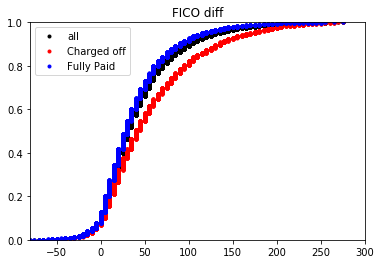

All Loans

count    23510.000000

mean        41.753977

std         44.937476

min        -80.000000

25%         10.000000

50%         30.000000

75%         60.000000

max        275.000000

Name: diff_fico_high, dtype: float64

Bad Loans (21%)

count    5032.000000

mean       56.096979

std        55.197095

min       -60.000000

25%        15.000000

50%        40.000000

75%        85.000000

max       275.000000

Name: diff_fico_high, dtype: float64


Passing Loans (78.59%)

count    18478.000000

mean        37.848036

std         40.846952

min        -80.000000

25%         10.000000

50%         30.000000

75%         55.000000

max        275.000000

Name: diff_fico_high, dtype: float64

In [6]:
df_i = df.loc[df.application_type == 'Individual']
df_j = df.loc[df.application_type != 'Individual']

df_i.drop(columns=['application_type'], inplace=True)
df_j.drop(columns=['application_type'], inplace=True)

C:\Users\leero\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [7]:
import numpy as np
np.sum(df.collection_recovery_fee)

98270395.91558258

In [8]:
for thing in df_i:
    print(thing)

loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
emp_length
annual_inc
loan_status
dti
delinq_2yrs
fico_range_low
fico_range_high
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
collection_recovery_fee
collections_12_mths_ex_med
mths_since_last_major_derog
annual_inc_joint
dti_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
delinq_amnt
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recent_revol_delinq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_

In [16]:
np.sum(df.open_acc_6m)

954754.0

In [13]:
for thing in df_i:
    if df_i[thing].isnull().values.any():
        print(thing)

inq_last_6mths
mths_since_last_delinq
mths_since_last_record
collections_12_mths_ex_med
mths_since_last_major_derog
annual_inc_joint
tot_coll_amt
tot_cur_bal
open_acc_6m
open_act_il
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc_util
chargeoff_within_12_mths
mo_sin_old_il_acct
mo_sin_old_rev_tl_op
mo_sin_rcnt_rev_tl_op
mo_sin_rcnt_tl
mort_acc
mths_since_recent_bc
mths_since_recent_bc_dlq
mths_since_recent_inq
mths_since_recent_revol_delinq
num_accts_ever_120_pd
num_actv_bc_tl
num_actv_rev_tl
num_bc_sats
num_bc_tl
num_il_tl
num_op_rev_tl
num_rev_accts
num_rev_tl_bal_gt_0
num_sats
num_tl_120dpd_2m
num_tl_30dpd
num_tl_90g_dpd_24m
num_tl_op_past_12m
pct_tl_nvr_dlq
percent_bc_gt_75
pub_rec_bankruptcies
tax_liens
tot_hi_cred_lim
total_bal_ex_mort
total_bc_limit
total_il_high_credit_limit
revol_bal_joint


In [11]:
# Dropping all joint and secondary linked features

df_i.drop(columns=['sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_inq_last_6mths', 'sec_app_mort_acc',
                   'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths',
                   'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'dti_joint','sec_app_open_act_il'], inplace=True)

C:\Users\leero\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [12]:
from sklearn.model_selection import train_test_split

X = df_i.drop(['loan_status'],axis=1)
y = df_i.loan_status

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)